#Ranking Universes by Factors




One common technique in quantitative finance is that of ranking stocks in some way. This ranking can be whatever you come up with, but will often be a combination of fundamental factors and price-based signals. One example could be the following

1. Score stocks based on 0.5 x the PE Ratio of that stock + 0.5 x the 30 day price momentum
2. Rank stocks based on that score

These ranking systems can be used to construct long-short equity strategies.

In order to develop a good ranking system, we need to first understand how to evaluate ranking systems. We will show a demo here.

##WARNING: 
This notebook does analysis over thousands of equities and hundreds of timepoints. The resulting memory usage can crash the research server if you are running other notebooks. Please shut down other notebooks in the main research menu before running this notebook. You can tell if other notebooks are running by checking the color of the notebook symbol. Green indicates running, grey indicates not.

In [1]:
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
import scipy
from statsmodels import regression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Getting Data
The first thing we're gonna do is get monthly values for the Market Cap, P/E Ratio and Monthly Returns for every equity. Monthly Returns is a metric that takes the returns accrued over an entire month of trading by dividing the last close price by the first close price and subtracting 1.

In [2]:

        
def make_pipeline():
    """
    Create and return our pipeline.
    
    We break this piece of logic out into its own function to make it easier to
    test and modify in isolation.
    """
    
    pipe = Pipeline(
        columns = {
            'Market Cap' : morningstar.valuation.market_cap.latest,
            'PE Ratio' : morningstar.valuation_ratios.pe_ratio.latest,
            'Monthly Returns': Returns(window_length=21),
        })
    
    return pipe

pipe = make_pipeline()

Let's take a look at the data to get a quick sense of what we have. This may take a while.

In [4]:


start_date = '2013-01-01'
end_date = '2015-02-01'

data = run_pipeline(pipe, start_date, end_date)

# remove NaN values
data = data.dropna()

# show data
data

Market Cap  Monthly Returns  \
2013-01-02 00:00:00+00:00 Equity(2 [AA])        8.975170e+09         0.032143   
                          Equity(21 [AAME])     6.228180e+07         0.065580   
                          Equity(24 [AAPL])     5.505680e+11        -0.089110   
                          Equity(31 [ABAX])     8.283930e+08         0.008415   
                          Equity(52 [ABM])      1.037840e+09         0.053308   
                          Equity(53 [ABMD])     5.296030e+08         0.008621   
                          Equity(62 [ABT])      4.916000e+10         0.008154   
                          Equity(64 [ABX])      3.455270e+10         0.014778   
                          Equity(66 [AB])       1.848950e+09        -0.007688   
                          Equity(67 [ADSK])     7.444310e+09         0.066727   
                          Equity(69 [ACAT])     4.985790e+08        -0.115538   
                          Equity(76 [TAP])      7.513120e+09         0.034208   
                          Equity(84 [ACET])     2.710310e+08         0.013798   
                          Equity(88 [ACI])      1.426500e+09         0.089153   
                          Equity(99 [ACO])      9.648460e+08         0.023727   
                          Equity(100 [IEP])     4.212790e+09         0.107074   
                          Equity(106 [ACU])     3.430780e+07         0.008284   
                          Equity(110 [ACXM])    1.319010e+09        -0.012450   
                          Equity(112 [ACY])     2.004690e+07         0.084681   
                          Equity(114 [ADBE])    1.710190e+10         0.088099   
                          Equity(122 [ADI])     1.223640e+10         0.044177   
                          Equity(128 [ADM])     1.758370e+10         0.025843   
                          Equity(153 [AE])      1.471520e+08        -0.003438   
                          Equity(154 [AEM])     9.589180e+09        -0.059362   
                          Equity(157 [AEG])     1.096140e+10         0.125654   
                          Equity(161 [AEP])     2.069590e+10         0.000469   
                          Equity(162 [AEPI])    3.346250e+08        -0.012629   
                          Equity(166 [AES])     7.938060e+09         0.005162   
                          Equity(168 [AET])     1.444710e+10         0.072222   
                          Equity(185 [AFL])     2.484740e+10         0.003021   
...                                                      ...              ...   
2015-02-02 00:00:00+00:00 Equity(47858 [NMS])   6.352770e+07         0.075804   
                          Equity(47873 [OMAM])  1.854000e+09        -0.067692   
                          Equity(47875 [VBTX])  1.237870e+08        -0.064286   
                          Equity(47876 [MOLG])  1.302750e+08        -0.372549   
                          Equity(47883 [DPLO])  1.336120e+09        -0.102920   
                          Equity(47884 [PLAY])  1.146320e+09         0.051592   
                          Equity(47888 [FCAU])  1.627660e+10         0.143104   
                          Equity(47894 [KIQ])   2.109430e+08        -0.228376   
                          Equity(47898 [GWB])   1.199980e+09        -0.112478   
                          Equity(47904 [SRSC])  9.647810e+08        -0.030177   
                          Equity(47913 [XENE])  2.444860e+08        -0.113924   
                          Equity(47921 [KEYS])  5.652700e+09        -0.012718   
                          Equity(47923 [KE])    3.170760e+08        -0.149042   
                          Equity(47935 [ABCW])  3.094400e+08         0.008735   
                          Equity(47949 [APTO])  5.733000e+07        -0.156303   
                          Equity(47980 [BOOT])  5.036520e+08         0.108791   
                          Equity(48002 [FFWM])  1.465090e+08        -0.017641   
                          Equity(48019 [TBK])   2.346070e+08        -0.039882   


Now, we need to take each of these individual factors, clean them to remove NaN values and aggregate them for each month.

In [5]:
cap_data = data['Market Cap'].transpose().unstack() # extract series of data
cap_data = cap_data.T.dropna().T # remove NaN values
cap_data = cap_data.resample('M', how='last') # use last instance in month to aggregate

pe_data = data['PE Ratio'].transpose().unstack()
pe_data = pe_data.T.dropna().T
pe_data = pe_data.resample('M', how='last')

month_data = data['Monthly Returns'].transpose().unstack()
month_data = month_data.T.dropna().T
month_data = month_data.resample('M', how='last')

The next step is to figure out which equities we have data for. Data sources are never perfect, and stocks go in and out of existence with Mergers, Acquisitions, and Bankruptcies. We'll make a list of the stocks common to all three sources (our factor data sets) and then filter down both to just those stocks.

In [6]:
common_equities = cap_data.T.index.intersection(pe_data.T.index).intersection(month_data.T.index)

Now, we will make sure that each time series is being run over identical an identical set of securities.

In [7]:
cap_data_filtered = cap_data[common_equities][:-1]
month_forward_returns = month_data[common_equities][1:]
pe_data_filtered = pe_data[common_equities][:-1]

Here, is the filtered data for market cap over all equities for the first 5 months, as an example.

In [8]:
cap_data_filtered.head()

,Equity(2 [AA]),Equity(24 [AAPL]),Equity(31 [ABAX]),Equity(52 [ABM]),Equity(62 [ABT]),Equity(64 [ABX]),Equity(66 [AB]),Equity(67 [ADSK]),Equity(69 [ACAT]),Equity(76 [TAP]),...,Equity(43476 [BERY]),Equity(43479 [FLTX]),Equity(43493 [ANFI]),Equity(43494 [SSTK]),Equity(43495 [AMBA]),Equity(43512 [FANG]),Equity(43514 [SHOS]),Equity(43572 [WWAV]),Equity(43599 [RH]),Equity(43627 [RKUS])
2013-01-31 00:00:00+00:00,9263400000,4.996960e+11,828393000,1085530000,49412800000,35048800000,1833170000,7943140000,440098000,7513120000,...,1678870000,749643000,288533000,871338000,290937000,707182000,752136000,2688420000,1279280000,975600000
2013-02-28 00:00:00+00:00,9434150000,4.277320e+11,852731000,1085530000,53214500000,31955400000,2141330000,8693570000,476344000,8200170000,...,1987300000,867043000,245378000,845533000,290937000,829238000,752136000,2800870000,1279280000,1736040000
2013-03-31 00:00:00+00:00,9110660000,4.145000e+11,937567000,1240500000,53073200000,30273500000,2422140000,8217940000,478849000,8022940000,...,2172600000,821391000,256434000,1092660000,269269000,839964000,1029570000,2705720000,1465930000,1587240000
2013-04-30 00:00:00+00:00,9110660000,4.161420e+11,1046720000,1215370000,55059100000,29433900000,2309700000,9231750000,577001000,8924830000,...,2154440000,876024000,227074000,1507590000,423369000,992719000,932085000,2953110000,1328870000,1560850000
2013-05-31 00:00:00+00:00,9089870000,4.156150e+11,944303000,1215370000,57553300000,19732700000,2498490000,8813240000,594034000,9411840000,...,2148790000,847847000,219620000,1397660000,423369000,971266000,1030490000,2925430000,1328870000,1435260000


Because we're dealing with ranking systems, at several points we're going to want to rank our data. Let's check how our data looks when ranked to get a sense for this.

In [9]:
cap_data_filtered.rank().head()

,Equity(2 [AA]),Equity(24 [AAPL]),Equity(31 [ABAX]),Equity(52 [ABM]),Equity(62 [ABT]),Equity(64 [ABX]),Equity(66 [AB]),Equity(67 [ADSK]),Equity(69 [ACAT]),Equity(76 [TAP]),...,Equity(43476 [BERY]),Equity(43479 [FLTX]),Equity(43493 [ANFI]),Equity(43494 [SSTK]),Equity(43495 [AMBA]),Equity(43512 [FANG]),Equity(43514 [SHOS]),Equity(43572 [WWAV]),Equity(43599 [RH]),Equity(43627 [RKUS])
2013-01-31 00:00:00+00:00,9.0,14,3,1.5,1,25,2,2,4,1,...,1,1,9,2,2.5,1,18.5,1,1.5,5
2013-02-28 00:00:00+00:00,10.0,7,6,1.5,5,24,7,7,8,3,...,2,4,5,1,2.5,2,18.5,3,1.5,25
2013-03-31 00:00:00+00:00,7.5,3,11,5.0,4,23,14,5,9,2,...,5,2,7,3,1.0,3,23.0,2,5.0,24
2013-04-30 00:00:00+00:00,7.5,5,17,3.5,7,22,10,11,14,5,...,4,5,2,5,5.5,5,20.0,6,3.5,23
2013-05-31 00:00:00+00:00,5.5,4,14,3.5,12,12,18,8,15,11,...,3,3,1,4,5.5,4,24.0,5,3.5,22


## Looking at Correlations Over Time

Now that we have the data, let's do something with it. Our first analysis will be to measure the monthly Spearman rank correlation coefficient between Market Cap and month-forward returns. In other words, how predictive of 30-day returns is ranking your universe by market cap.

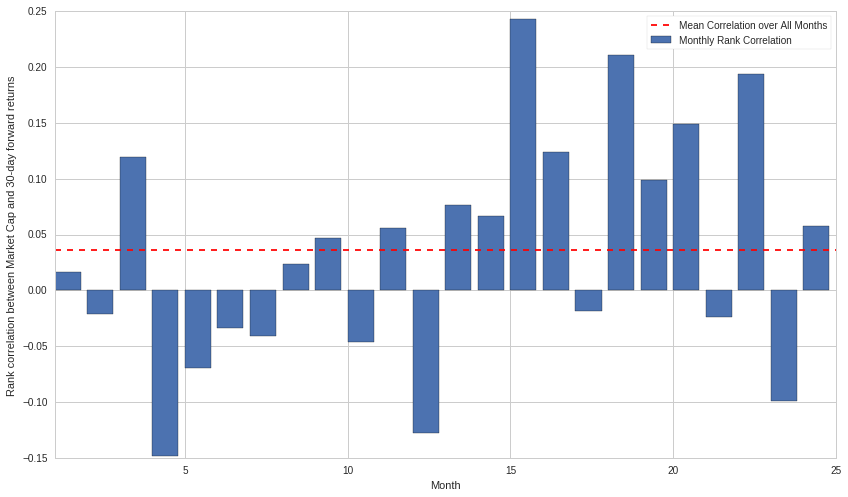

In [10]:
scores = np.zeros(24)
pvalues = np.zeros(24)
for i in range(24):
    score, pvalue = stats.spearmanr(cap_data_filtered.iloc[i], month_forward_returns.iloc[i])
    pvalues[i] = pvalue
    scores[i] = score
    
plt.bar(range(1,25),scores)
plt.hlines(np.mean(scores), 1, 25, colors='r', linestyles='dashed')
plt.xlabel('Month')
plt.xlim((1, 25))
plt.legend(['Mean Correlation over All Months', 'Monthly Rank Correlation'])
plt.ylabel('Rank correlation between Market Cap and 30-day forward returns');

We can see that the average correlation is positive, but varies a lot from month to month.

Let's look at the same analysis, but with PE Ratio.

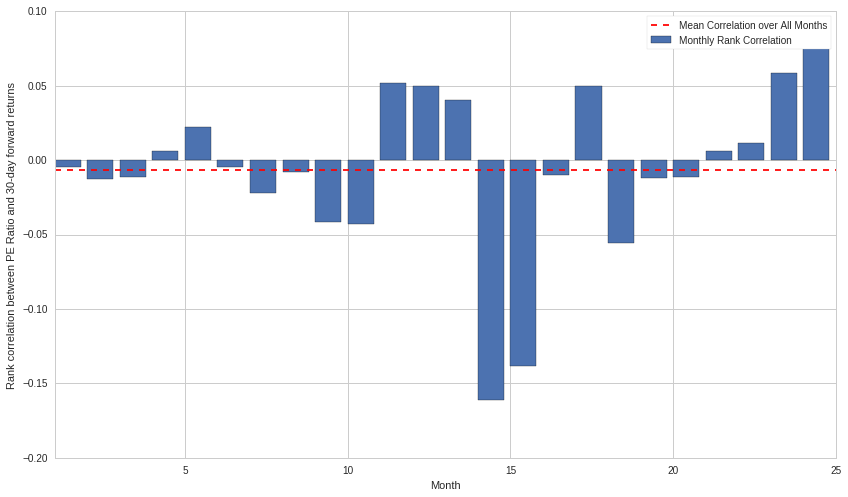

In [11]:
scores = np.zeros(24)
pvalues = np.zeros(24)
for i in range(24):
    score, pvalue = stats.spearmanr(pe_data_filtered.iloc[i], month_forward_returns.iloc[i])
    pvalues[i] = pvalue
    scores[i] = score
    
plt.bar(range(1,25),scores)
plt.hlines(np.mean(scores), 1, 25, colors='r', linestyles='dashed')
plt.xlabel('Month')
plt.xlim((1, 25))
plt.legend(['Mean Correlation over All Months', 'Monthly Rank Correlation'])
plt.ylabel('Rank correlation between PE Ratio and 30-day forward returns');

The correlation of PE Ratio and 30-day returns seems to be near 0 on average. It's important to note that this monthly and between 2012 and 2015. Different factors are predictive on differen timeframes and frequencies, so the fact that PE Ratio doesn't appear predictive here is not necessary throwing it out as a useful factor. Beyond it's usefulness in predicting returns, it can be used for risk exposure analysis.

## Basket Returns

The next step is to compute the returns of baskets taken out of our ranking. If we rank all equities and then split them into $n$ groups, what would the mean return be of each group? We can answer this question in the following way. The first step is to create a function that will give us the mean return in each basket in a given the month and a ranking factor.

In [12]:
def compute_basket_returns(factor_data, forward_returns, number_of_baskets, month):

    data = pd.concat([factor_data.iloc[month-1],forward_returns.iloc[month-1]], axis=1)
    # Rank the equities on the factor values
    data.columns = ['Factor Value', 'Month Forward Returns']
    data.sort('Factor Value', inplace=True)
    
    # How many equities per basket
    equities_per_basket = np.floor(len(data.index) / number_of_baskets)

    basket_returns = np.zeros(number_of_baskets)

    # Compute the returns of each basket
    for i in range(number_of_baskets):
        start = i * equities_per_basket
        if i == number_of_baskets - 1:
            # Handle having a few extra in the last basket when our number of equities doesn't divide well
            end = len(data.index) - 1
        else:
            end = i * equities_per_basket + equities_per_basket
        # Actually compute the mean returns for each basket
        basket_returns[i] = data.iloc[start:end]['Month Forward Returns'].mean()
        
    return basket_returns

The first thing we'll do with this function is compute this for each month and then average. This should give us a sense of the relationship over a long timeframe.

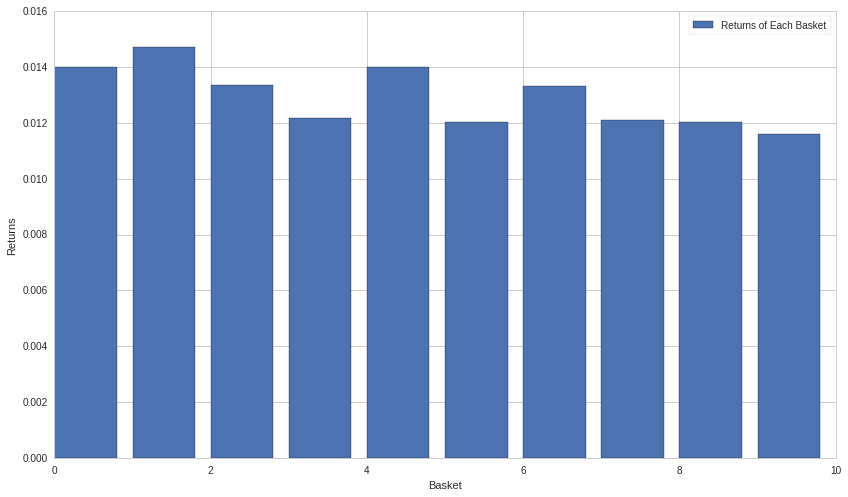

In [13]:
number_of_baskets = 10
mean_basket_returns = np.zeros(number_of_baskets)
for m in range(1, 25):
    basket_returns = compute_basket_returns(cap_data_filtered, month_forward_returns, number_of_baskets, m)
    mean_basket_returns += basket_returns

mean_basket_returns /= 24    

# Plot the returns of each basket
plt.bar(range(number_of_baskets), mean_basket_returns)
plt.ylabel('Returns')
plt.xlabel('Basket')
plt.legend(['Returns of Each Basket']);

### Spread Consistency

Of course, that's just the average relationship. To get a sense of how consistent this is, and whether or not we would want to trade on it, we should look at it over time. Here we'll look at the monthly spreads for the first year. We can see a lot of variation, and further analysis should be done to determine whether Market Cap is tradeable.

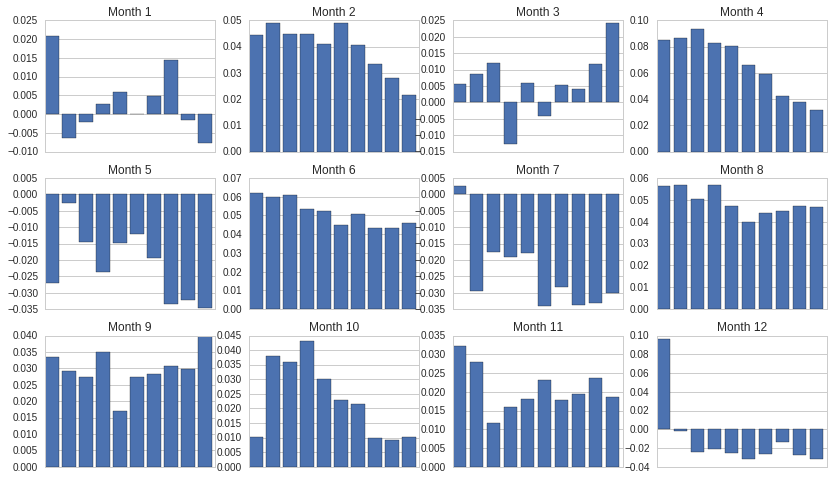

In [14]:
f, axarr = plt.subplots(3, 4)
for month in range(1, 13):
    basket_returns = compute_basket_returns(cap_data_filtered, month_forward_returns, 10, month)

    r = np.floor((month-1) / 4)
    c = (month-1) % 4
    axarr[r, c].bar(range(number_of_baskets), basket_returns)
    axarr[r, c].xaxis.set_visible(False) # Hide the axis lables so the plots aren't super messy
    axarr[r, c].set_title('Month ' + str(month))

We'll repeat the same analysis for PE Ratio.

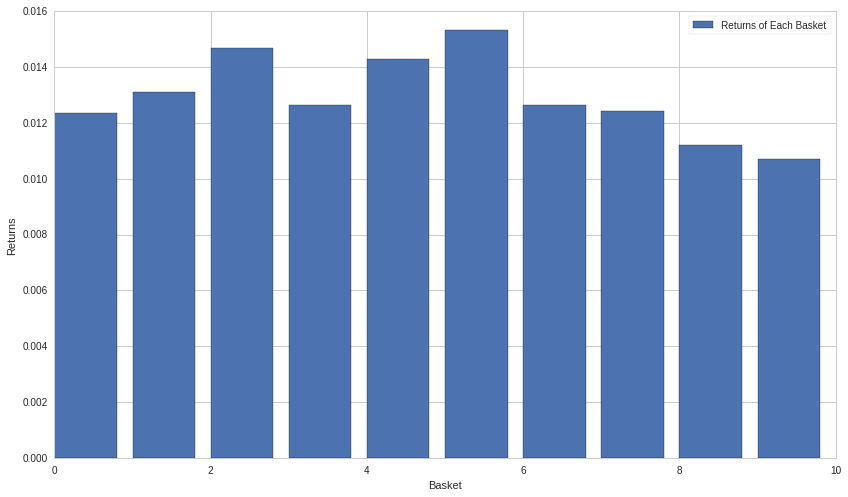

In [15]:
number_of_baskets = 10
mean_basket_returns = np.zeros(number_of_baskets)
for m in range(1, 25):
    basket_returns = compute_basket_returns(pe_data_filtered, month_forward_returns, number_of_baskets, m)
    mean_basket_returns += basket_returns

mean_basket_returns /= 24    

# Plot the returns of each basket
plt.bar(range(number_of_baskets), mean_basket_returns)
plt.ylabel('Returns')
plt.xlabel('Basket')
plt.legend(['Returns of Each Basket']);

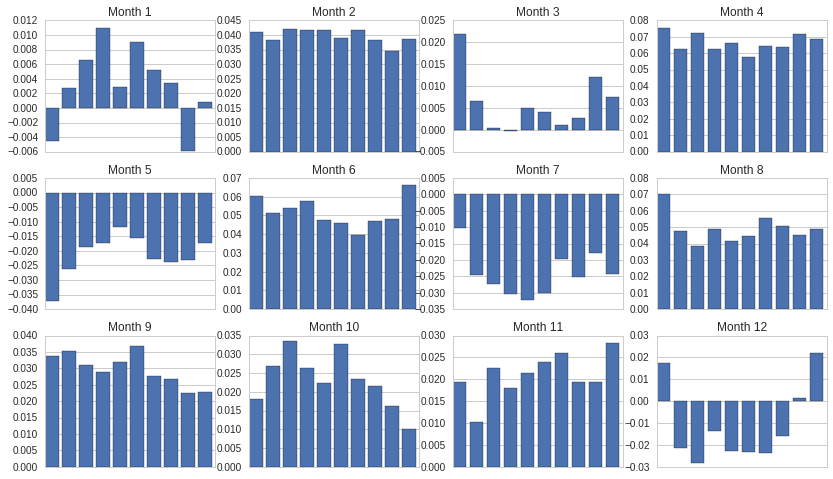

In [16]:
f, axarr = plt.subplots(3, 4)
for month in range(1, 13):
    basket_returns = compute_basket_returns(pe_data_filtered, month_forward_returns, 10, month)

    r = np.floor((month-1) / 4)
    c = (month-1) % 4
    axarr[r, c].bar(range(10), basket_returns)
    axarr[r, c].xaxis.set_visible(False) # Hide the axis lables so the plots aren't super messy
    axarr[r, c].set_title('Month ' + str(month))

## Sometimes Factors are Just Other Factors

Often times a new factor will be discovered that seems to induce spread, but it turns out that it is just a new and potentially more complicated way to compute a well known factor. Consider for instance the case in which you have poured tons of resources into developing a new factor, it looks great, but how do you know it's not just another factor in disguise?

To check for this, there are many analyses that can be done.

### Correlation Analysis

One of the most intuitive ways is to check what the correlation of the factors is over time. We'll plot that here.

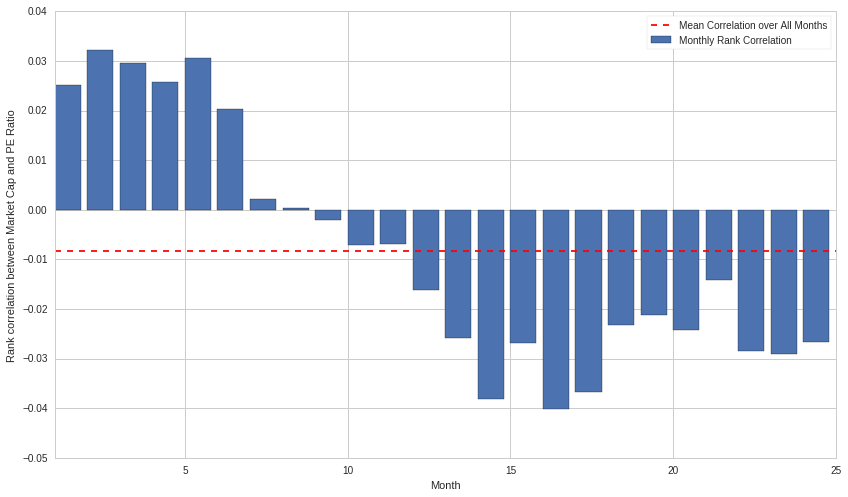

In [17]:
scores = np.zeros(24)
pvalues = np.zeros(24)
for i in range(24):
    score, pvalue = stats.spearmanr(cap_data_filtered.iloc[i], pe_data_filtered.iloc[i])
    pvalues[i] = pvalue
    scores[i] = score
    
plt.bar(range(1,25),scores)
plt.hlines(np.mean(scores), 1, 25, colors='r', linestyles='dashed')
plt.xlabel('Month')
plt.xlim((1, 25))
plt.legend(['Mean Correlation over All Months', 'Monthly Rank Correlation'])
plt.ylabel('Rank correlation between Market Cap and PE Ratio');

And also the p-values because the correlations may not be that meaningful by themselves.

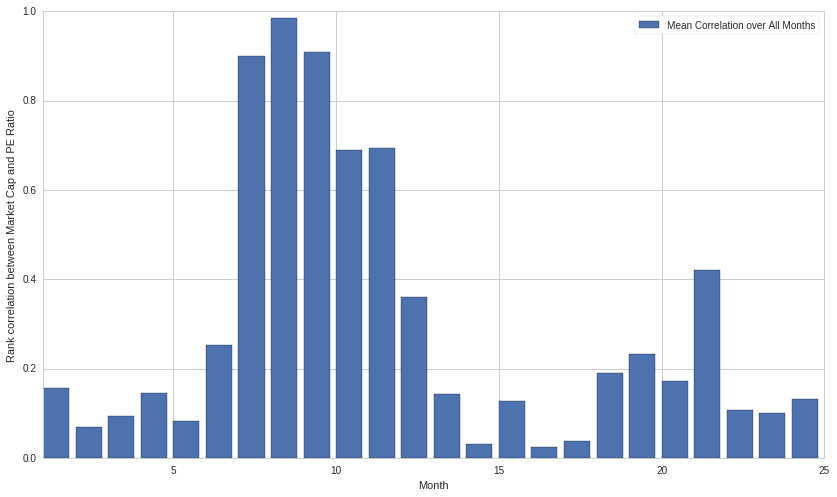

In [18]:
scores = np.zeros(24)
pvalues = np.zeros(24)
for i in range(24):
    score, pvalue = stats.spearmanr(cap_data_filtered.iloc[i], pe_data_filtered.iloc[i])
    pvalues[i] = pvalue
    scores[i] = score
    
plt.bar(range(1,25),pvalues)
plt.xlabel('Month')
plt.xlim((1, 25))
plt.legend(['Mean Correlation over All Months', 'Monthly Rank Correlation'])
plt.ylabel('Rank correlation between Market Cap and PE Ratio');

There is interesting behavior, and further analysis would be needed to determine whether a relationship existed.

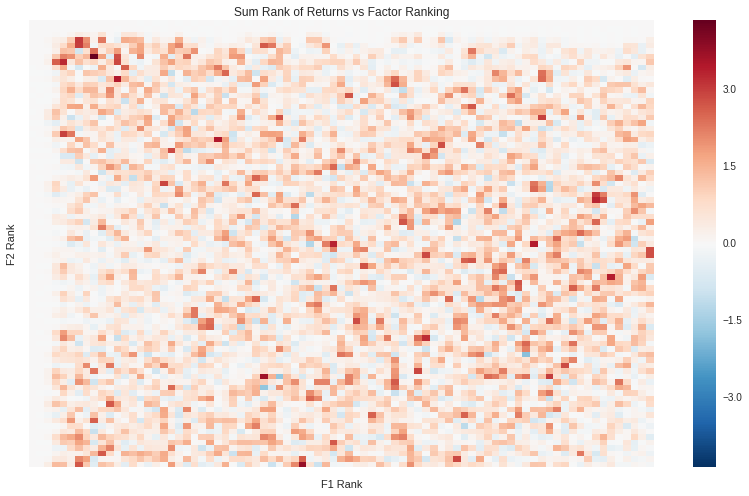

In [19]:
pe_dataframe = pd.DataFrame(pe_data_filtered.iloc[0])
pe_dataframe.columns = ['F1']
cap_dataframe = pd.DataFrame(cap_data_filtered.iloc[0])
cap_dataframe.columns = ['F2']
returns_dataframe = pd.DataFrame(month_forward_returns.iloc[0])
returns_dataframe.columns = ['Returns']

data = pe_dataframe.join(cap_dataframe).join(returns_dataframe)

data = data.rank(method='first')

heat = np.zeros((len(data), len(data)))

for e in data.index:
    F1 = data.loc[e]['F1']
    F2 = data.loc[e]['F2']
    R = data.loc[e]['Returns']
    heat[F1-1, F2-1] += R
    
heat = scipy.signal.decimate(heat, 40)
heat = scipy.signal.decimate(heat.T, 40).T

p = sns.heatmap(heat, xticklabels=[], yticklabels=[])
# p.xaxis.set_ticks([])
# p.yaxis.set_ticks([])
p.xaxis.set_label_text('F1 Rank')
p.yaxis.set_label_text('F2 Rank')
p.set_title('Sum Rank of Returns vs Factor Ranking');

##How to Choose  Ranking System

The ranking system is the secret sauce of many strategies. Choosing a good ranking system, or factor, is not easy and the subject of much research. We'll discuss a few starting points here.

### Clone and Tweak

Choose one that is commonly discussed and see if you can modify it slightly to gain back an edge. Often times factors that are public will have no signal left as they have been completely arbitraged out of the market. However, sometimes they lead you in the right direction of where to go.

### Pricing Models

Any model that predicts future returns can be a factor. The future return predicted is now that factor, and can be used to rank your universe. You can take any complicated pricing model and transform it into a ranking.

### Price Based Factors (Technical Indicators)

Price based factors take information about the historical price of each equity and use it to generate the factor value. Examples could be 30-day momentum, or volatility measures.

#### Reversion vs. Momentum

It's important to note that some factors bet that prices, once moving in a direction, will continue to do so. Some factors bet the opposite. Both are valid models on different time horizons and assets, and it's important to investigate whether the underlying behavior is momentum or reversion based.

### Fundamental Factors (Value Based)

This is using combinations of fundamental values as we discussed today. Fundamental values contain information that is tied to real world facts about a company, so in many ways can be more robust than prices.

### The Arms Race

Ultimately, developing predictive factors is an arms race in which you are trying to stay one step ahead. Factors get arbitraged out of markets and have a lifespan, so it's important that you are constantly doing work to determine how much decay your factors are experiencing, and what new factors might be used to take their place.